In [1]:
!pip install deepxde yfinance pandas matplotlib --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.9 MB/s eta 0:00:00


In [2]:
import yfinance as yf
import pandas as pd

df = pd.read_csv("/content/AAPL.csv")
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 1. Load the data
# Assuming stock data is in a CSV file named 'stock_data.csv'
# with columns like 'Date', 'Open', 'High', 'Low', 'Close', 'Volume'
#df = pd.read_csv('stock_data.csv')

# Convert the 'Date' column to datetime objects and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Select the feature(s) to use for prediction
# For this example, the 'Close' price is used
data = df[['Close']]

# 2. Preprocessing
# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create training sequences (e.g., using a sliding window)
# Let's say we want to use the previous 'n_steps' days to predict the next day
n_steps = 30 # Number of previous days to consider for prediction
num_future_steps = 10 # Number of future steps to predict

X = []
y = []
y_trunk = []

for i in range(n_steps, len(scaled_data) - num_future_steps):
    X.append(scaled_data[i-n_steps:i, 0])
    y.append(scaled_data[i:i+num_future_steps, 0])
    y_trunk.append(np.arange(num_future_steps).reshape(-1, 1) / num_future_steps) # Normalized future time steps

X, y, y_trunk = np.array(X), np.array(y), np.array(y_trunk)

# Reshape the data for LSTM input
# LSTM input shape: [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


# 3. Split into training and testing sets
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
y_train_trunk, y_test_trunk = y_trunk[:train_size], y_trunk[train_size:]

In [4]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_train_trunk:", y_train_trunk.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of y_test_trunk:", y_test_trunk.shape)

Shape of X_train: (7258, 30, 1)
Shape of y_train: (7258, 10)
Shape of y_train_trunk: (7258, 10, 1)
Shape of X_test: (3111, 30, 1)
Shape of y_test: (3111, 10)
Shape of y_test_trunk: (3111, 10, 1)


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the Branch Network
def build_branch_net(input_shape, embedding_dim):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(128),
        layers.Dense(64, activation='relu'),
        layers.Dense(embedding_dim) # Output dimension for combining with trunk
    ])
    return model

# Define the Trunk Network
def build_trunk_net(input_shape, embedding_dim):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(), # Flatten the input for the Dense layers
        layers.Dense(64, activation='relu'),
        layers.Dense(embedding_dim) # Output dimension for combining with branch
    ])
    return model

# Define the DeepONet
def build_deeponet(branch_input_shape, trunk_input_shape, embedding_dim, num_future_steps):
    branch_input = keras.Input(shape=branch_input_shape)
    trunk_input = keras.Input(shape=trunk_input_shape)

    branch_output = build_branch_net(branch_input_shape, embedding_dim)(branch_input)
    trunk_output = build_trunk_net(trunk_input_shape, embedding_dim)(trunk_input)

    # Combine outputs (dot product along the embedding dimension)
    combined_output = layers.Dot(axes=-1)([branch_output, trunk_output])

    # Add a Dense layer to predict the next num_future_steps
    output = layers.Dense(num_future_steps)(combined_output)


    model = keras.Model(inputs=[branch_input, trunk_input], outputs=output)
    return model

# Example Usage:
embedding_dim = 128
sequence_length = 30 # e.g., 60 days
num_features = 1 # Changed to 1 to match the actual input data shape
num_future_steps = 10 # e.g., 10 future days
branch_input_shape = (sequence_length, num_features) # e.g., (60, 1)
trunk_input_shape = (num_future_steps, 1) # e.g., (10, 1) for 10 future days

deeponet_model = build_deeponet(branch_input_shape, trunk_input_shape, embedding_dim, num_future_steps)
deeponet_model.compile(optimizer='adamw', loss='mse',metrics=["mae"])
deeponet_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128)       │     83,136 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 128)       │      9,024 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ sequential[0][0], │
│                     │                   │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 10)        │         20 │ dot[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 92,180 (360.08 KB)

 Trainable params: 92,180 (360.08 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
deeponet_model.summary(print_fn=lambda x: print(x))

Model: "functional_2"
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128)       │     83,136 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 128)       │      9,024

In [7]:
BOLD = "\033[1m"
#RESET = "\033[0m"

deeponet_model.summary(print_fn=lambda x: print(f"{BOLD}{x}"))

Model: "functional_2"
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128)       │     83,136 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 128)       │      9,024

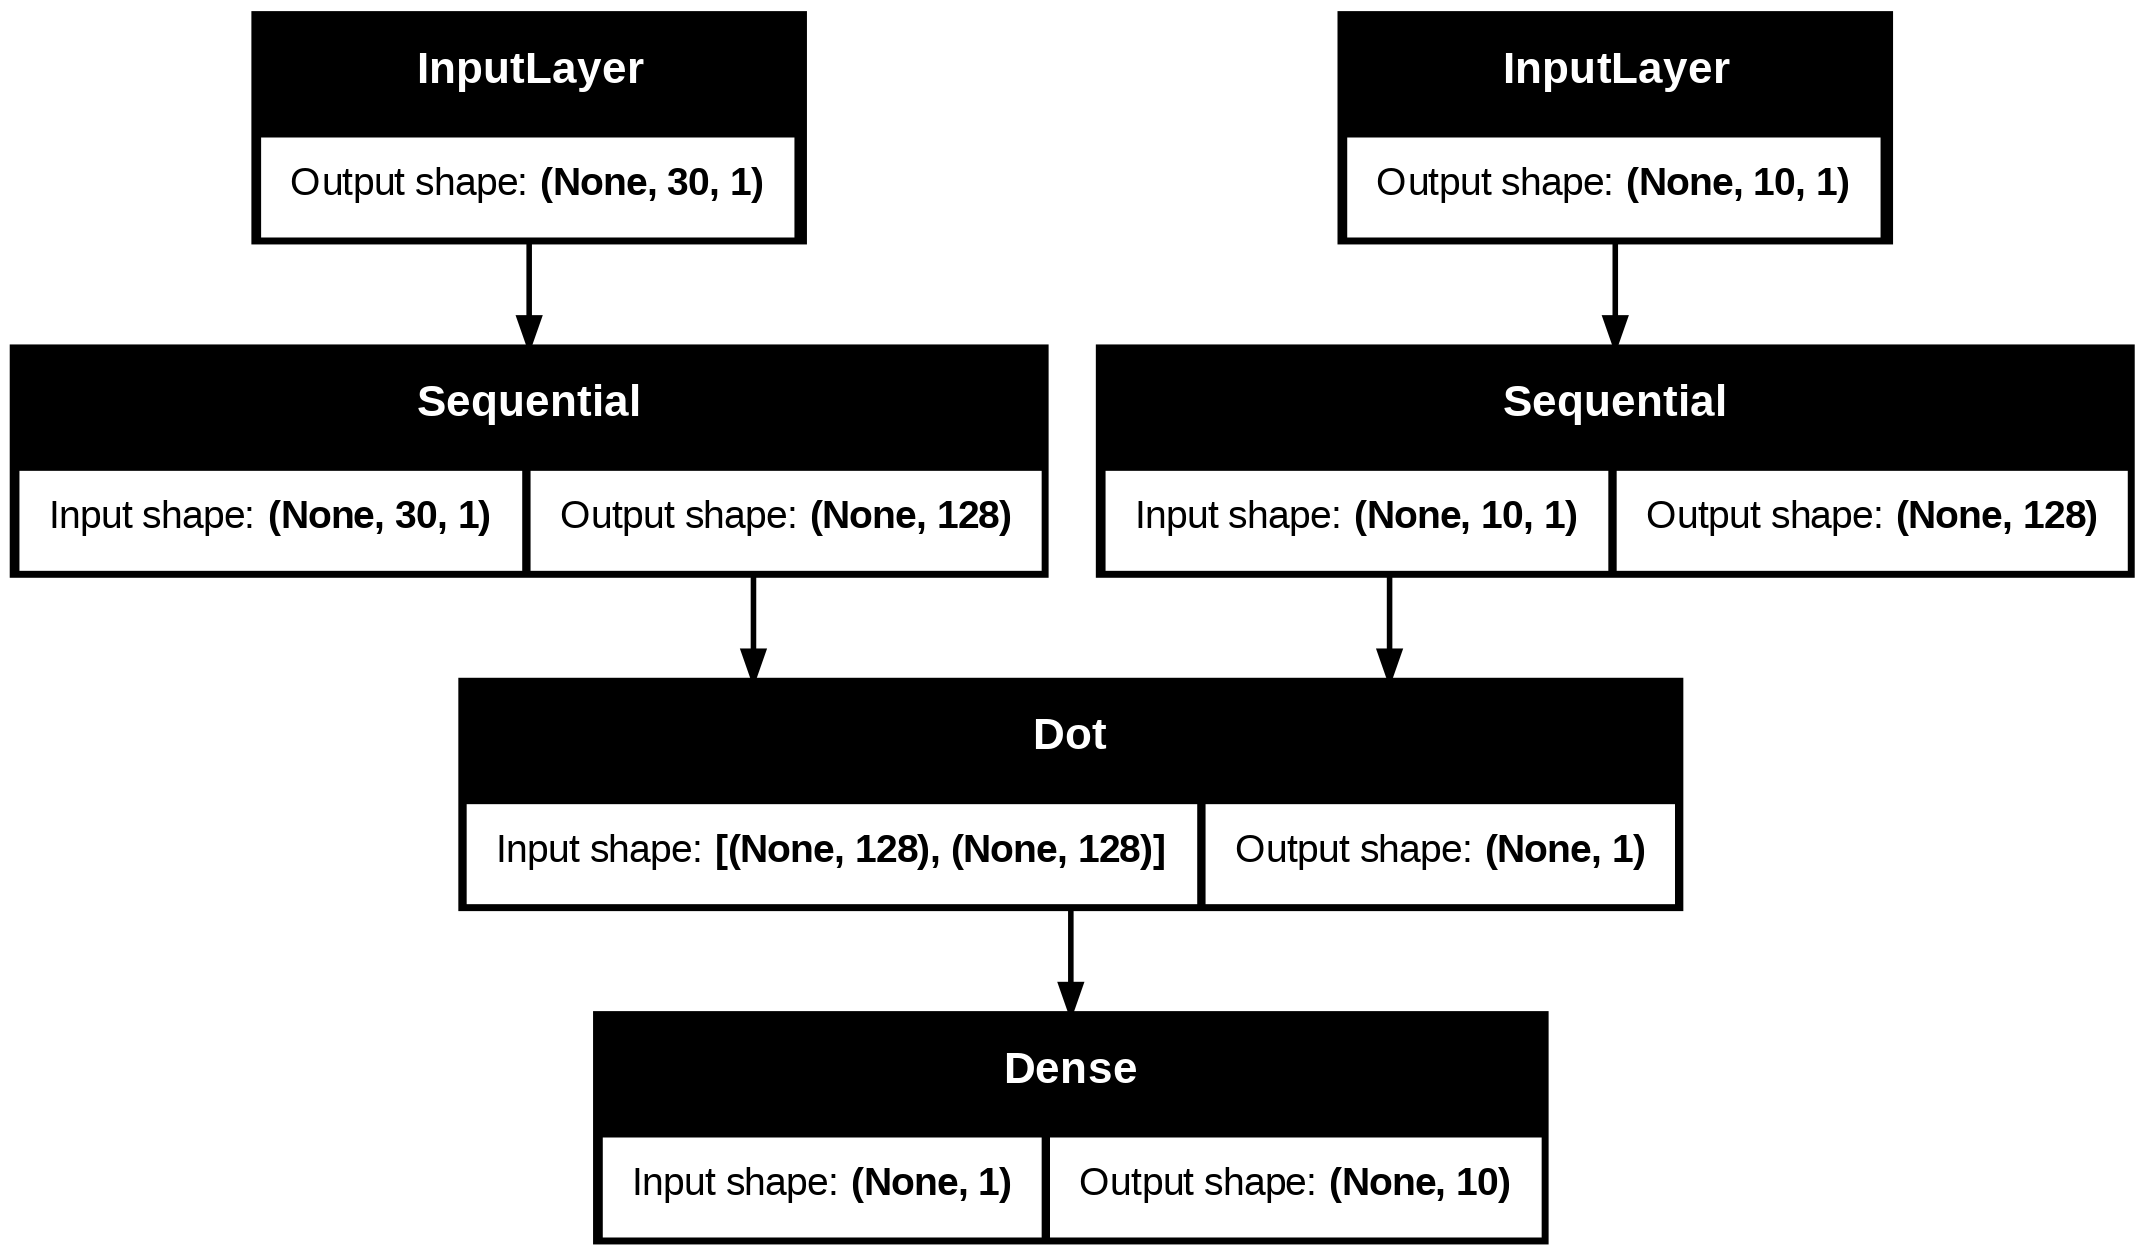

In [8]:
keras.utils.plot_model(deeponet_model, show_shapes=True)

In [9]:
deeponet_model.fit(x=[X_train, y_train_trunk], y=y_train, epochs=150, batch_size=32, validation_data=([X_test, y_test_trunk], y_test))

Epoch 1/150
227/227 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 6.9894e-05 - mae: 0.0055 - val_loss: 0.0984 - val_mae: 0.2233
Epoch 2/150
227/227 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 5.1405e-05 - mae: 0.0042 - val_loss: 0.0498 - val_mae: 0.1327
Epoch 3/150
227/227 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 2.1689e-05 - mae: 0.0023 - val_loss: 0.0208 - val_mae: 0.0719
Epoch 4/150
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 8.4992e-06 - mae: 0.0015 - val_loss: 0.0099 - val_mae: 0.0575
Epoch 5/150
227/227 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 2.1820e-06 - mae: 8.0473e-04 - val_loss: 0.0048 - val_mae: 0.0420
Epoch 6/150
227/227 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 9.8026e-07 - mae: 6.5897e-04 - val_loss: 0.0036 - val_mae: 0.0368
Epoch 7/150
227/227 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 1.1575e-06 - mae: 7.5647e-04 - val_loss: 0.0028 - val_mae: 0.0319
Epoch 8/150
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 7.8834e-07 - mae: 5.7216e-04 - val_loss: 0.0023 - va

# New Section

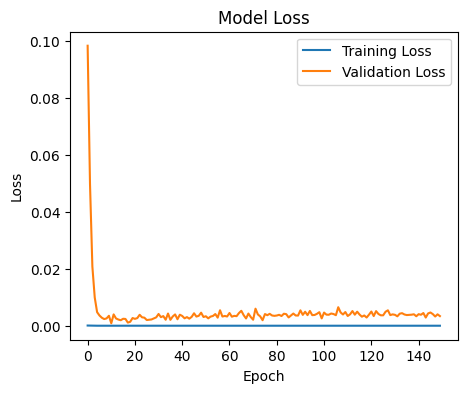

In [10]:
# Plot training and validation loss
history = deeponet_model.history.history
plt.figure(figsize=(5, 4))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

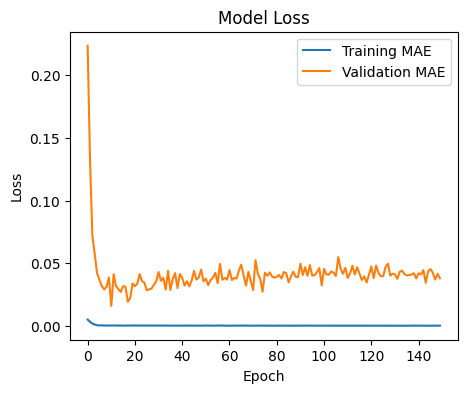

In [11]:
history = deeponet_model.history.history
plt.figure(figsize=(5, 4))
plt.plot(history['mae'], label='Training MAE')
plt.plot(history['val_mae'], label='Validation MAE')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


,Actual,Predicted
0,6.732143,6.959719
1,6.761071,6.795225
2,6.741071,6.759338
3,6.814643,6.743454
4,6.929643,6.795102


<Axes: >

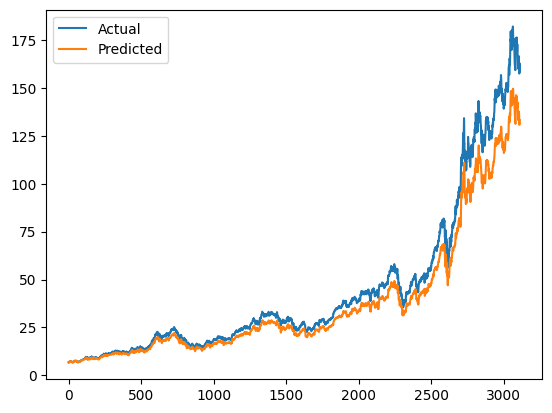

In [12]:
y_pred_train = deeponet_model.predict([X_train, y_train_trunk])
y_pred_test = deeponet_model.predict([X_test, y_test_trunk])

# Inverse transform the scaled data
y_pred_train_inv = scaler.inverse_transform(y_pred_train)
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_train_inv = scaler.inverse_transform(y_train)
y_test_inv = scaler.inverse_transform(y_test)

# Create a DataFrame to compare actual and predicted values for the first predicted step
# Fixing the ValueError by creating a DataFrame with a list of dictionaries
df_pred = pd.DataFrame([{'Actual': y_test_inv[i][0], 'Predicted': y_pred_test_inv[i][0]} for i in range(len(y_test_inv))])
# Display the head of the DataFrame
display(df_pred.head())
df_pred.plot()


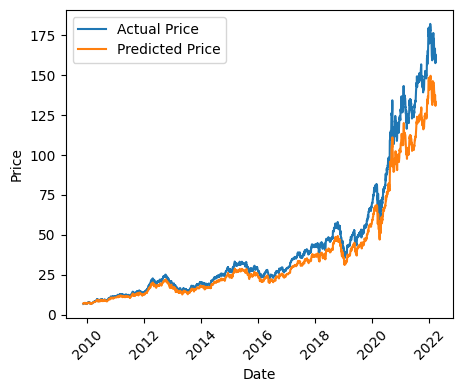

In [13]:
# Get the dates for the test set
test_dates = df.index[train_size + n_steps + num_future_steps -1:] # Adjust index to match the start of the prediction window

# Create a DataFrame for plotting with dates as index
df_plot = pd.DataFrame({'Actual': y_test_inv[:, 0], 'Predicted': y_pred_test_inv[:, 0]}, index=test_dates[:len(y_test_inv)])

# Plot actual vs predicted values
plt.figure(figsize=(5, 4))
plt.plot(df_plot.index, df_plot['Actual'], label='Actual Price')
plt.plot(df_plot.index, df_plot['Predicted'], label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(False)
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_inv[:, 0], y_pred_test_inv[:, 0]))

print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 9.840329590452738


In [15]:
from sklearn.metrics import r2_score

# Calculate R-squared
r2 = r2_score(y_test_inv[:, 0], y_pred_test_inv[:, 0])

print(f"R-squared (R2): {r2}")

R-squared (R2): 0.941781446595756


In [16]:
import numpy as np

# Calculate residuals
residuals = y_test_inv[:, 0] - y_pred_test_inv[:, 0]

# Calculate the standard error of the residuals
standard_error = np.std(residuals)

print(f"Standard Error of Residuals: {standard_error}")

Standard Error of Residuals: 7.377262365637561


In [17]:
!pip install deepxde --quiet
import deepxde as dde

No backend selected.
Finding available backend...
Found tensorflow
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Setting the default backend to "tensorflow". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [25]:
print(X_train.shape)
print(y_train_trunk.shape)
print(X_test.shape)
print(y_test_trunk.shape)


(7258, 30, 1)
(7258, 10, 1)
(3111, 30, 1)
(3111, 10, 1)


227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step


,Actual,Predicted
0,6.732143,6.959719
1,6.761071,6.795225
2,6.741071,6.759338
3,6.814643,6.743454
4,6.929643,6.795102


<Axes: >

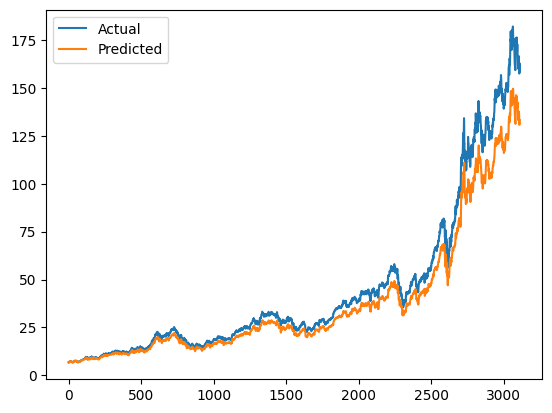

In [30]:
# This code was part of an attempt to predict after data was overwritten by the DeepXDE section.
# The fix is to remove the DeepXDE section to prevent data overwriting.

y_pred_train = deeponet_model.predict([X_train, y_train_trunk])
y_pred_test = deeponet_model.predict([X_test, y_test_trunk])

# Inverse transform the scaled data
y_pred_train_inv = scaler.inverse_transform(y_pred_train)
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_train_inv = scaler.inverse_transform(y_train)
y_test_inv = scaler.inverse_transform(y_test)

# Create a DataFrame to compare actual and predicted values for the first predicted step
# Fixing the ValueError by creating a DataFrame with a list of dictionaries
df_pred = pd.DataFrame([{'Actual': y_test_inv[i][0], 'Predicted': y_pred_test_inv[i][0]} for i in range(len(y_test_inv))])
# Display the head of the DataFrame
display(df_pred.head())
df_pred.plot()

In [31]:
# Use closing price
data = df[["Close"]]
data.head()

,Close
Date,
1980-12-12,0.128348
1980-12-15,0.121652
1980-12-16,0.112723
1980-12-17,0.115513
1980-12-18,0.118862


In [32]:
for i in range(1, 6):   # past 5 days
    data[f"lag_{i}"] = data["Close"].shift(i)

data.dropna(inplace=True)


/tmp/ipython-input-4100869011.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f"lag_{i}"] = data["Close"].shift(i)
/tmp/ipython-input-4100869011.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f"lag_{i}"] = data["Close"].shift(i)
/tmp/ipython-input-4100869011.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [33]:
from sklearn.model_selection import train_test_split

X = data.drop("Close", axis=1)
y = data["Close"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [34]:
from sklearn.linear_model import LinearRegression

model_daily = LinearRegression()
model_daily.fit(X_train, y_train)

daily_pred = model_daily.predict(X_test)


In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, daily_pred))
mae = mean_absolute_error(y_test, daily_pred)
r2 = r2_score(y_test, daily_pred)

print("Daily Prediction Metrics:")
print("RMSE:", rmse)
print("MAE :", mae)
print("R²  :", r2)


Daily Prediction Metrics:
RMSE: 1.3989097975747145
MAE : 0.7888424853066688
R²  : 0.9989536274302377


In [36]:
monthly_data = df["Close"].resample("M").mean()
monthly_data = monthly_data.to_frame()
monthly_data.head()


/tmp/ipython-input-4228266086.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df["Close"].resample("M").mean()


,Close
Date,
1980-12-31,0.135903
1981-01-31,0.141316
1981-02-28,0.117892
1981-03-31,0.110871
1981-04-30,0.121545


In [37]:
for i in range(1, 4):  # past 3 months
    monthly_data[f"lag_{i}"] = monthly_data["Close"].shift(i)

monthly_data.dropna(inplace=True)


In [38]:
X_m = monthly_data.drop("Close", axis=1)
y_m = monthly_data["Close"]

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_m, y_m, test_size=0.2, shuffle=False
)


In [39]:
model_monthly = LinearRegression()
model_monthly.fit(X_train_m, y_train_m)

monthly_pred = model_monthly.predict(X_test_m)


In [40]:
rmse_m = np.sqrt(mean_squared_error(y_test_m, monthly_pred))
mae_m = mean_absolute_error(y_test_m, monthly_pred)
r2_m = r2_score(y_test_m, monthly_pred)

print("Monthly Prediction Metrics:")
print("RMSE:", rmse_m)
print("MAE :", mae_m)
print("R²  :", r2_m)


Monthly Prediction Metrics:
RMSE: 5.043821514840653
MAE : 3.3366649697261814
R²  : 0.9865195314302261


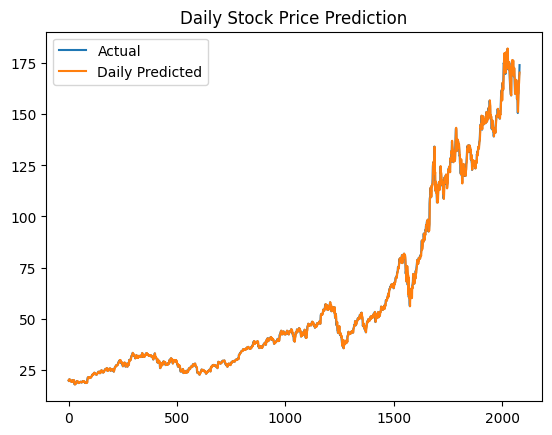

In [41]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(y_test.values, label="Actual")
plt.plot(daily_pred, label="Daily Predicted")
plt.legend()
plt.title("Daily Stock Price Prediction")
plt.show()


In [42]:
from sklearn.linear_model import LinearRegression

train_data = monthly_data[monthly_data.index < "2024-01-01"]

X_train = train_data.drop("Close", axis=1)
y_train = train_data["Close"]

model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [43]:
# The original error occurred because monthly_data does not contain data for 2024.
# The `monthly_data` DataFrame currently ends on 2022-03-31.
# To demonstrate future prediction, we will adjust the training and testing periods
# to use the available data.

# Re-define training data up to the end of 2021
train_data_adjusted = monthly_data[monthly_data.index < "2022-01-01"]

X_train_adjusted = train_data_adjusted.drop("Close", axis=1)
y_train_adjusted = train_data_adjusted["Close"]

# Re-initialize and train the model with the adjusted training data
from sklearn.linear_model import LinearRegression
model_forecast = LinearRegression() # Use a new model name to avoid confusion
model_forecast.fit(X_train_adjusted, y_train_adjusted)

# Define the prediction period for 2022 (within available data)
test_period_2022 = monthly_data[
    (monthly_data.index >= "2022-01-01") &
    (monthly_data.index <= "2022-12-31") # Predict for all of 2022 within available data
]

X_2022 = test_period_2022.drop("Close", axis=1)
y_actual_2022 = test_period_2022["Close"]

# Make predictions using the retrained model
y_pred_2022 = model_forecast.predict(X_2022)

# Assign to original variable names for consistency if they are used later
y_actual_2024 = y_actual_2022
y_pred_2024 = y_pred_2022

print("Actual values for the prediction period (2022):")
print(y_actual_2022)
print("\nPredicted values for the prediction period (2022):")
print(y_pred_2022)

Actual values for the prediction period (2022):
Date
2022-01-31    169.861500
2022-02-28    169.830001
2022-03-31    162.248889
Freq: ME, Name: Close, dtype: float64

Predicted values for the prediction period (2022):
[180.78377515 170.96732613 175.96962693]


In [44]:
results_2024 = pd.DataFrame({
    "Actual_Price": y_actual_2024.values,
    "Predicted_Price": y_pred_2024
}, index=y_actual_2024.index)

results_2024


,Actual_Price,Predicted_Price
Date,,
2022-01-31,169.861500,180.783775
2022-02-28,169.830001,170.967326
2022-03-31,162.248889,175.969627


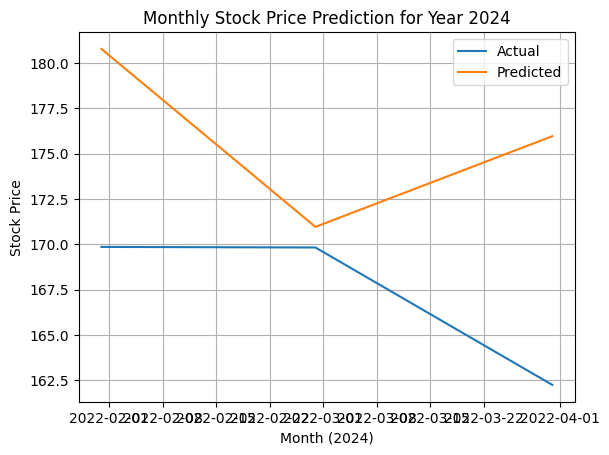

In [45]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(results_2024.index, results_2024["Actual_Price"], label="Actual")
plt.plot(results_2024.index, results_2024["Predicted_Price"], label="Predicted")

plt.xlabel("Month (2024)")
plt.ylabel("Stock Price")
plt.title("Monthly Stock Price Prediction for Year 2024")
plt.legend()
plt.grid(True)

plt.show()


In [46]:
df["Daily_Return"] = df["Close"].pct_change()


In [47]:
daily_volatility = df["Daily_Return"].std()
print("Daily Volatility:", daily_volatility)


Daily Volatility: 0.028367848373307095


In [48]:
monthly_volatility = df["Daily_Return"].resample("M").std()


/tmp/ipython-input-2404256171.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_volatility = df["Daily_Return"].resample("M").std()


In [49]:
import numpy as np

annual_volatility = daily_volatility * np.sqrt(252)
print("Annualized Volatility:", annual_volatility)


Annualized Volatility: 0.45032563215455257


In [50]:
jan_2024_volatility = monthly_volatility["2022-01"]

In [51]:
volatility_2024 = monthly_volatility["2022"]

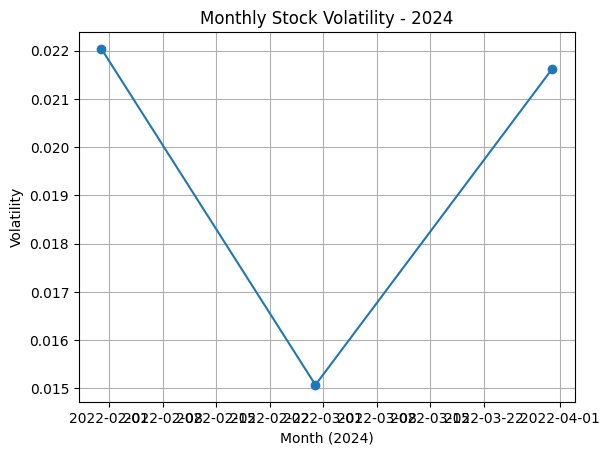

In [52]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(volatility_2024.index, volatility_2024.values, marker='o')

plt.xlabel("Month (2024)")
plt.ylabel("Volatility")
plt.title("Monthly Stock Volatility - 2024")
plt.grid(True)

plt.show()
